## Group 14
Dario Puggioni, ID: 2107760

ALberto Salvador, ID: 2112317

Giancarlo Saran Gattorno, ID: 2106359

Gaia Volpi, ID: 2107759

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 2.0.3


### Selecting and visualizing training and test set

In [2]:
# selecting training set and test set 
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=4000, N_train=3000, L=4


Part of the data:
[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 1
[ 24.771  46.131 -49.161 -39.356] 1
[-20.13   15.641  30.981  37.218] 1
[46.465 22.369 14.248 21.745] 1


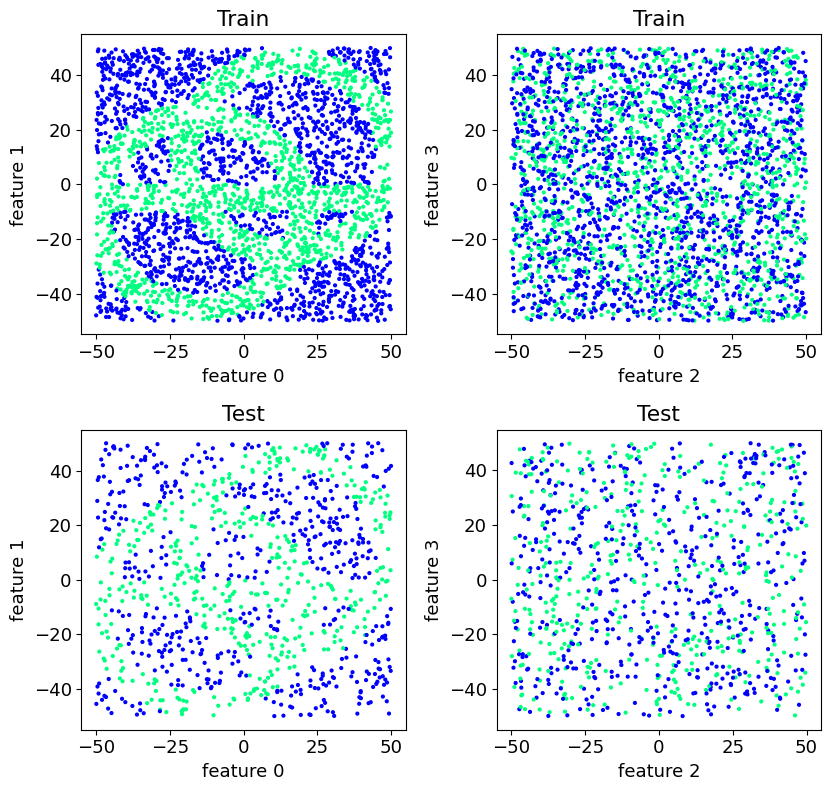

In [3]:
# function to plot the different features of the data
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

print('Part of the data:')
for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

--------------------

In [4]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)

    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),
            clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### XGBoost best parameters
We classify the training set using XGBoost, evaluating its performance with different parameters.

errors: 5.20%   Accuracy=0.948


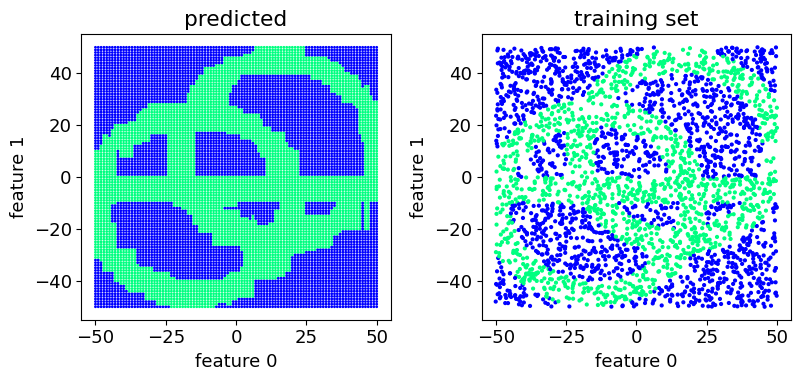

In [5]:
#default parameters

model = XGBClassifier(seed=1,
                      objective='binary:logistic') 
       # importance_type="gain" #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30 - number of trees
classify(model)

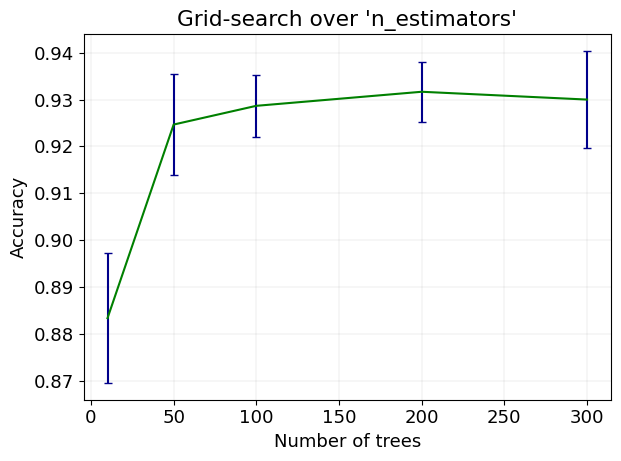

In [6]:
# we perform a gridsearch of the best number of trees for XGboost

param =dict(n_estimators = [10, 50, 100, 200, 300])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

ecolor, capsize='darkblue', 3
plt.errorbar(param['n_estimators'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'n_estimators'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

<span style="color:blue">  se mettessimo il commento relativo sotto ogni plot secondo me sarebbe più facile da leggere </span>
<span style="color:blue"> </span>

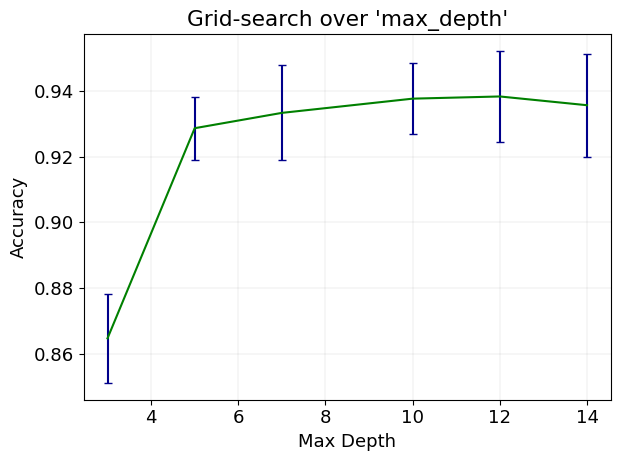

In [7]:
# we perform a gridsearch of the best tree depth for XGboost
param = dict(max_depth = [3, 5, 7, 10,12,14])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['max_depth'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'max_depth'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

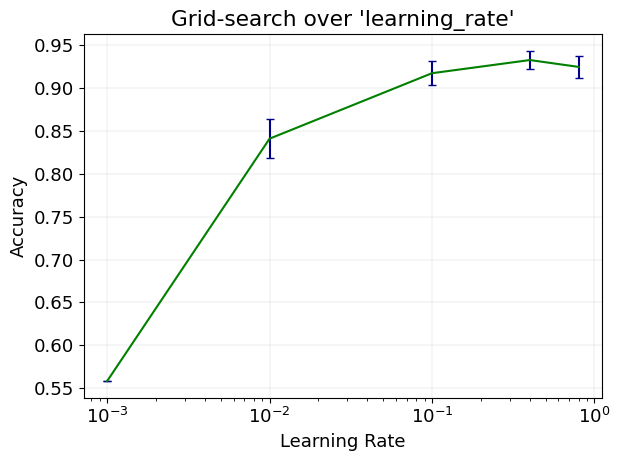

In [8]:
# we perform a gridsearch of the best learning rate for XGboost
param = dict(learning_rate = [0.8,0.4, 0.1, 0.01, 0.001])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['learning_rate'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'learning_rate'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

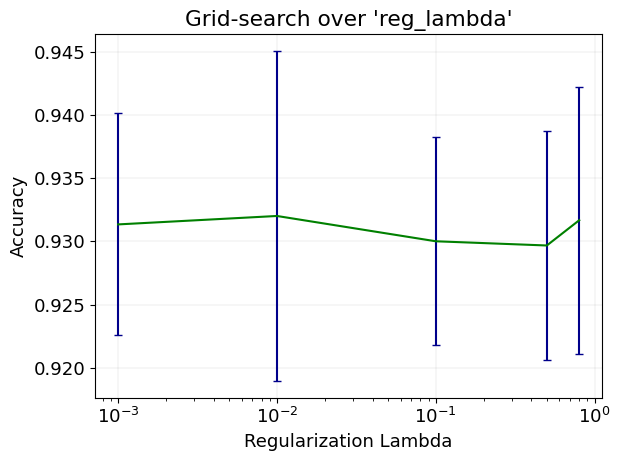

In [9]:
# we perform a gridsearch of the best regularization lambda for XGboost
param = dict(reg_lambda = [0.8, 0.5, 0.1, 0.01, 0.001])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['reg_lambda'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)
plt.xlabel('Regularization Lambda')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'reg_lambda'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

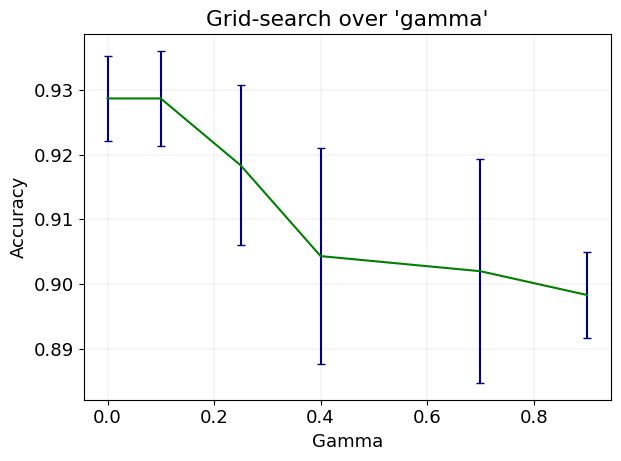

In [10]:
# we perform a gridsearch of the best gamma for XGboost
param = dict(gamma = [0, 0.1, 0.25, 0.4, 0.7, 0.9])
grid_search = GridSearchCV(model, param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
mean_acc = grid_result.cv_results_['mean_test_score']
std_acc = grid_result.cv_results_['std_test_score']

plt.errorbar(param['gamma'], mean_acc, yerr=std_acc, c='green', ecolor=ecolor, capsize=capsize)
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title("Grid-search over 'gamma'")
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.4)
plt.tight_layout()
plt.show()

We explored five parameters, varying each time one of them and keeping the default values for the others: 

1. For what concerns the number of trees (*n_estimators*), we see that after a certain limit adding more trees does not improve the performance of the model. The XGBoost algorithm indeed leads to a greater accuracy each time a new tree is added correcting the residuals errors in the predictions from the sequence of previous trees, this eventually leads to a point where no further significant improvements can be obtained. It is important to note that an increase in the number of trees implies a bigger computational burden, this is not justified if the improvement of the accuracy of the model is not significant.

2. By varying the size of the decision trees (*max_depth*), also called depth of the model, we see that the smallest value leads to a bad performance as the model is capable of capturing less details. Increasing the depth could on the other hand lead to <span style="color:blue"> overfitting, with deeper trees capturing too many details and losing the ability to generalize to new unseen data.  </span>There is a relationship between the number of trees in the model and the depth of each tree: a greater depth requires fewer trees while shallow ones require many more trees.

3. The learning rate $\eta$ (*learning_rate*) in XGBoost represents a shrinkage factor for the corrections by new trees when added to the model. The default value is equal to 1.0, smaller values slow down the adaptation of the model to the training data. This implies that more trees need to be added. The smallest value studied ($\eta$ = 0.001) leads to very poor performances with respect to the others.  

4. The lambda value $\lambda$ (*regularization_lambda*) refers to the L2 regularization term on weights, increasing this value will make the model more conservative and reduce overfitting. On the other hand a very high value of $\lambda$ may lead to an underfitting or a highly biased model. From the results obtained it seems that for our problem the value of this parameter, or even the absence of regularization ($\lambda$=0), does not affect much the overall performance of the model.

5. The gamma parameter $\gamma$ (*gamma*) is a pseudo-regularization hyperparameter, representing the "complexity cost by introducing additional leaf". By default it is set to 0, but it is useful if we want shallow trees. With our dataset and default values for XGBoost it seems that an increase of this parameter leads to worse performances. 

We proceed by performing a GridSearch of the best combination of these hyperparameters. As mentioned above some of them are stricly correlated and the performance of the model needs to be evaluated taking this into account:

<span style="color:blue">Non sono sicuro sia corretto parlare di overfit nel caso di queste foreste se aumentano gli alberi. Overfit è quando performa bene sul train ma male sul test. Da quanto avevo capito io all'aumentare di alberi inizia a fare divisioni in zone  in cui ha poco sensso fare divisione per il quadro generale</span>

In [35]:
# we perform a gridsearch of the best hyperparameters for XGboost
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.4, 0.1, 0.01, 0.001],
    'reg_lambda': [0.5, 0.1, 0.01, 0.0],
    'gamma': [0, 0.1, 0.4, 0.9]
    }

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_result = grid_search.fit(x_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
results = pd.DataFrame(grid_result.cv_results_)[['param_reg_lambda', 'param_gamma', 'param_n_estimators', 
                            'param_learning_rate', 'param_max_depth', 'mean_test_score', 'std_test_score']]

best_results = results.sort_values(by='mean_test_score', ascending=False).iloc[:10]
best_results

The above DataFrame shows the best 10 models obtained with our procedure. Taking into account the computational burden of adding more trees to the model, we choose as best model the one characterized by *n_estimators*=50, $\lambda$=0.5, $\gamma$=0, $\eta$=0.4 and *max_depth*=10. Given the stochastic nature of the algorithm the validation accuracy may vary, and with it the choice of the best parameters. We decide to proceed with the ones mentioned above as they seem to be a valid choice.

errors: 5.00%   Accuracy=0.950


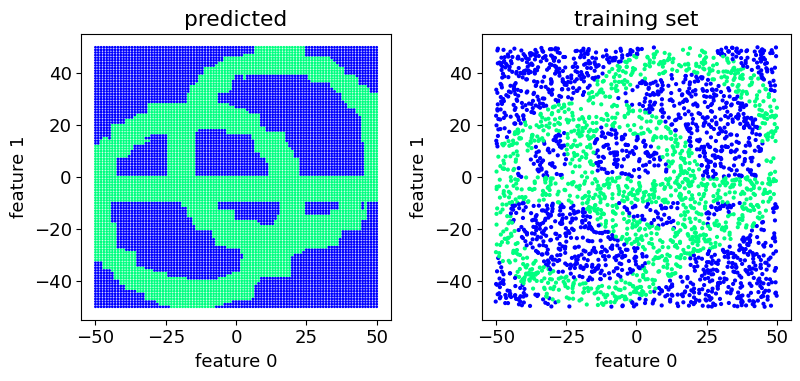

In [11]:
best_model = XGBClassifier(seed=1, objective='binary:logistic', n_estimators=50, 
                            reg_lambda=0.5, learning_rate=0.4, max_depth=10) 
classify(best_model)

-----------------------
## Dimensionality reduction

We look at the feature importance, considering then reduced data samples with $L’<L$ features.

None
[0.4891835  0.37623835 0.06590363 0.06867457]


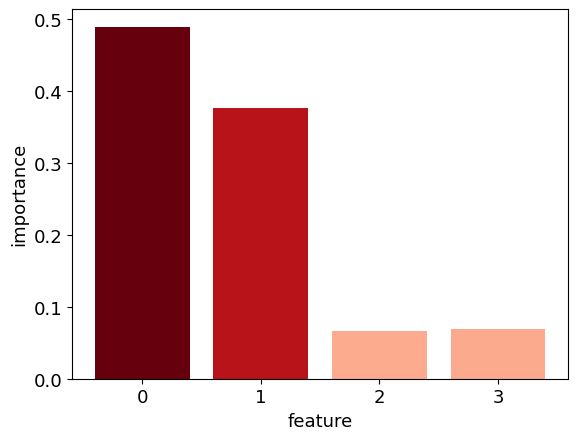

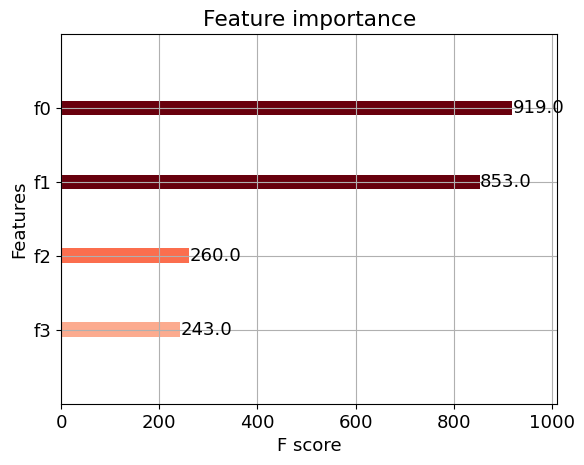

In [12]:
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()



    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [919. 853. 260. 243.]
1 gain [4.56883669 3.5139606  0.61552137 0.64140123]
2 total_gain [4198.76074219 2997.40844727  160.03555298  155.86050415]
3 cover [49.8643837  66.05692291 54.26316071 54.39147949]
4 total_cover [45825.3671875  56346.5546875  14108.421875   13217.12988281]


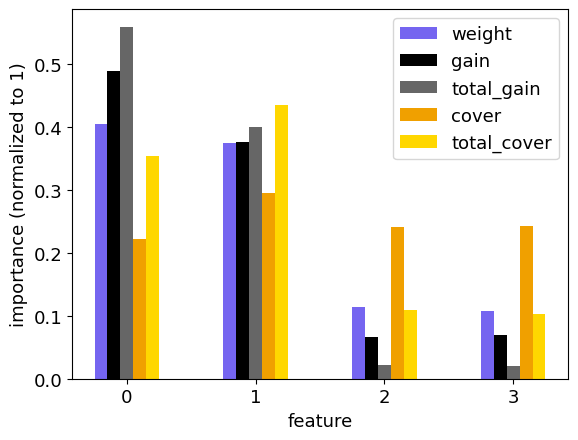

In [38]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

From the plots above it is clear that the most relevant features are the 0 and 1: let's try to remove 2 and 3 from the dataset and check whether there are some improvements in accuracy.

In [26]:
dname="./DATA/"
str0="_XGB_24.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
x = np.delete(x, 2, axis=1) #remove the 3rd feature
x = np.delete(x, 2, axis=1) #remove the 4th feature

y = np.loadtxt(fnamey)
y = y.astype(int)

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}",'\n')

N=4000, N_train=3000, L=2 



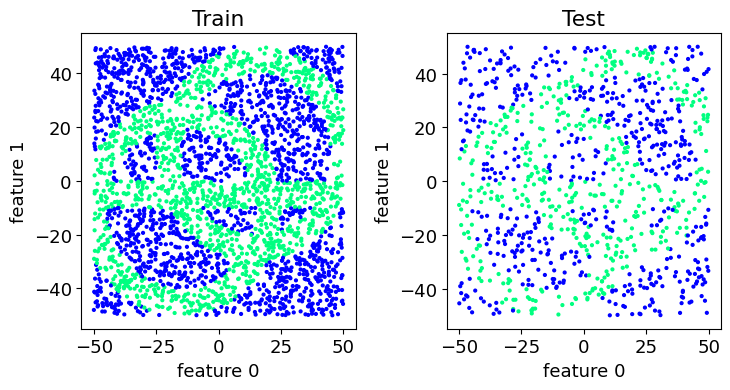

In [21]:
fig,AX = plt.subplots(1, 2, figsize=(7.5,4.1))
scat(AX[0],x_train,y_train,i=0,j=1,title="Train")
scat(AX[1],x_test,y_test,title="Test")
fig.tight_layout()
plt.show()

errors: 4.50%   Accuracy=0.955


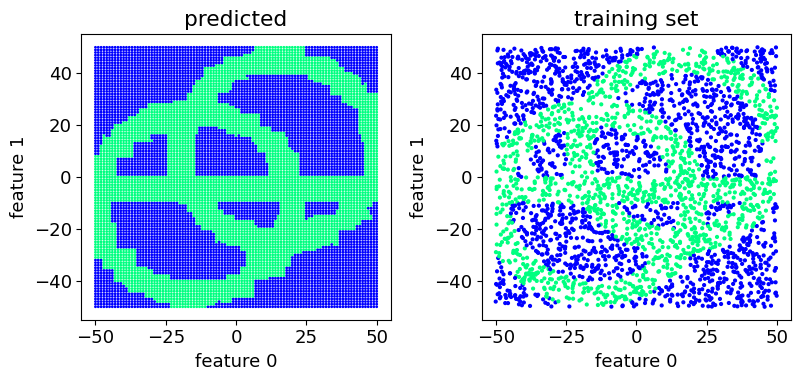

In [44]:
#XGBoost using default parameters

model = XGBClassifier(seed=1,objective='binary:logistic')  
classify(model)

We obtained a better result with respect to the case with the full dataset, with an improvement of the accuracy scorre from 0.948 to 0.955

Now we perform the grid search over the best parameters in order to see if we get further better results:


In [29]:
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.4, 0.1, 0.01, 0.001],
    'reg_lambda': [0.5, 0.1, 0.01, 0.0],
    'gamma': [0, 0.1, 0.4, 0.9]
    }

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_result = grid_search.fit(x_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)


Best set of hyperparameters:  {'gamma': 0, 'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.5}


errors: 4.10%   Accuracy=0.959


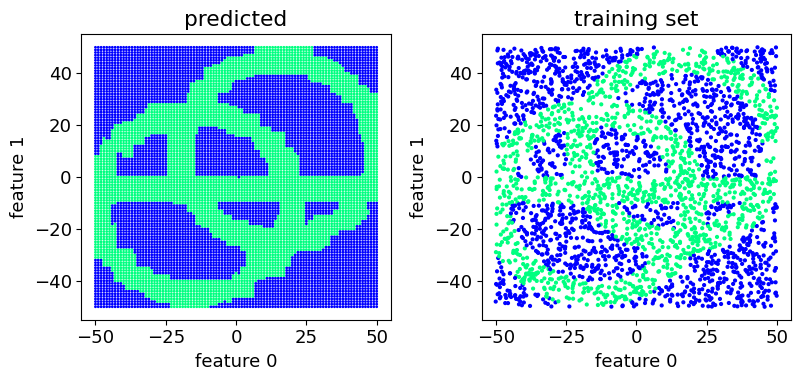

In [25]:
best_model = XGBClassifier(seed=1, objective='binary:logistic', n_estimators=100, 
                            reg_lambda=0.5, learning_rate=0.4, max_depth=7, gamma=0) 
classify(best_model)

We obtained as best hyper-parameters *n_estimators*=100, $\lambda$=0.5, $\gamma$=0, $\eta$=0.4 and *max_depth*=7, which are very similar to the results obtained for the full dataset. In addition to that one can see that as expected the accuracy is improved. We conclude that the other two features are almost useless for the classification task, almost as if they introduced noise in the process.

------------------------
### Normal Gradient Boosting

errors: 16.30%   Accuracy=0.837


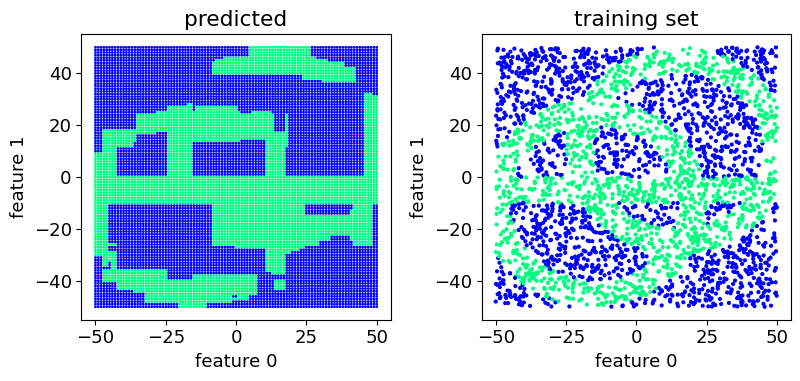

In [24]:
# GradientBoostingClassifier()
classify()

-------------
### AdaBoost

In [ ]:
classify(clf=AdaBoostClassifier())